In [12]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
#!pip install -q torchsummary --user
# from torchsummary import summary


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [13]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101);

In [14]:
path = "/data2/ntua/data/planet/planet"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 40479, test files: 40669


In [15]:
path_class = os.path.join(path, "train_classes.csv")
#df_class = pd.read_csv(path_class)
#df_class = df_class.sample(n=2000) # limit images
df_class = pd.read_csv('/data2/ntua/data/planet/planet/train_2000.csv')
print(df_class.shape)
print(df_class.head())

(2005, 4)
   Unnamed: 0   image_name                tags                     list_tags
0       15745  train_15745  haze primary water  ['haze', 'primary', 'water']
1       28604  train_28604        haze primary           ['haze', 'primary']
2       37088  train_37088        haze primary           ['haze', 'primary']
3       17034  train_17034        haze primary           ['haze', 'primary']
4       22727  train_22727        haze primary           ['haze', 'primary']


In [16]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
# df_tags = pd.DataFrame(
#     {"tag": counter_tags.keys(), "total": counter_tags.values()}
# ).sort_values("total")

# fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
#              color="total",
# )
# fig.update_layout(title="Class distribution")
# savefig(

In [17]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

In [18]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()
plt.savefig('classes_2000_50.png')

In [19]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [20]:
filenames = df_class.image_name.sample(600).values
#path_files = [os.path.join(path_train, filename+".jpg") for filename in filenames]
path_files = [os.path.join(path_train, filename+".jpg") for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
print('Train shape:', X_train_sample.shape)

Train shape: (600, 30000)


In [21]:
tsne = TSNE(
    n_components=2,
    init="random",
    random_state=101,
    method="barnes_hut",
    n_iter=500,
    verbose=2,
)
X_embedded = tsne.fit_transform(X_train_sample)
print('Embedded shape:',X_embedded.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.016s...
[t-SNE] Computed neighbors for 600 samples in 0.127s...


/data/miniconda3/envs/ntuaml4/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 7.232238
[t-SNE] Computed conditional probabilities in 0.045s
[t-SNE] Iteration 50: error = 76.9986572, gradient norm = 0.4160267 (50 iterations in 0.080s)
[t-SNE] Iteration 100: error = 82.7773361, gradient norm = 0.3256371 (50 iterations in 0.077s)
[t-SNE] Iteration 150: error = 78.7319565, gradient norm = 0.3880349 (50 iterations in 0.076s)
[t-SNE] Iteration 200: error = 81.8200531, gradient norm = 0.3397959 (50 iterations in 0.079s)
[t-SNE] Iteration 250: error = 83.5052719, gradient norm = 0.3390990 (50 iterations in 0.078s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.505272
[t-SNE] Iteration 300: error = 1.3636614, gradient norm = 0.0053122 (50 iterations in 0.073s)
[t-SNE] Iteration 350: error = 1.0745595, gradient norm = 0.0046416 (50 iterations in 0.075s)
[t-SNE] Iteration 400: error = 1.0249722, gradient norm = 0.0009720 (50 iterations in 0.070s)
[t-SNE] Iteration 45

In [22]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

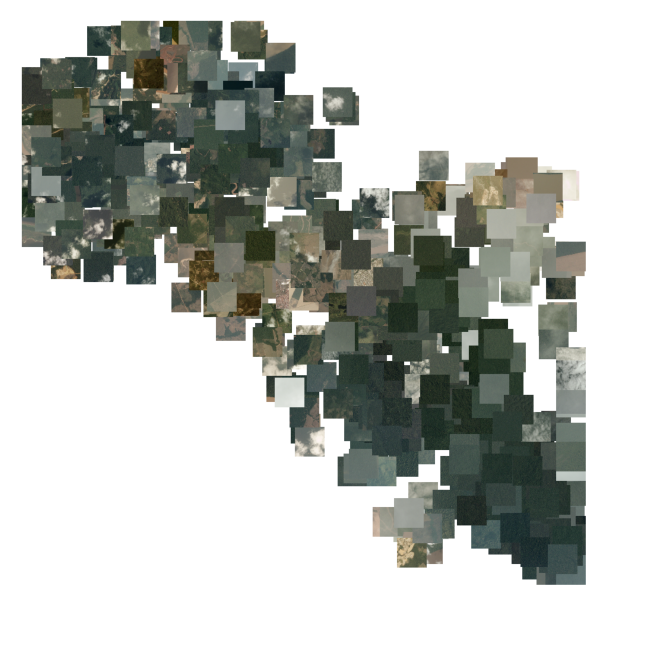

In [16]:
size_img = 1000
offset_img = 50
h = w = int(offset_img / 2)

X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
X_scaled = (X_scaled * size_img).astype(int)
X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

img_tsne = np.ones((size_img+2*offset_img, size_img+2*offset_img, 3), dtype=np.uint8) * 255
for idx in range(X_scaled.shape[0]):
    x, y = X_scaled[idx][0], X_scaled[idx][1]
    img = fetch_img(path_files[idx], h, w)
    img_tsne[x-w:x+w, y-h:y+h, :] = img

fig = plt.figure(figsize=(12, 12))
plt.imshow(img_tsne);
plt.axis("off");
plt.savefig('img_tsne_50.png')

In [23]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      )
    ])
    return transform_train, transform_val

In [24]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise AmazonDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.ohe_tags[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.custom_augment(img)
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
    def custom_augment(self, img):
        """
        Discrete rotation and horizontal flip.
        Random during training and non random during testing for TTA.
        Not implemented in torchvision.transforms, hence this function.
        """
        choice = np.random.randint(0, 6) if self.is_train else self.idx_tta
        if choice == 0:
            # Rotate 90
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        if choice == 1:
            # Rotate 90 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        if choice == 2:
            # Rotate 180
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
        if choice == 3:
            # Rotate 180 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
            img = cv2.flip(img, flipCode=1)
        if choice == 4:
            # Rotate 90 counter-clockwise
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        if choice == 5:
            # Rotate 90 counter-clockwise and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        return img

In [25]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = encoder.fit_transform(df_train.list_tags.values)
    ohe_tags_val = encoder.transform(df_val.list_tags.values)

    transform_train, transform_val = get_transforms()
    ds_train = AmazonDataset(df_train, ohe_tags_train, transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val, transform_val, path=path_train)

    dl_train = DataLoader(
      ds_train,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

In [26]:
df_class

Unnamed: 0   image_name  \
0          15745  train_15745   
1          28604  train_28604   
2          37088  train_37088   
3          17034  train_17034   
4          22727  train_22727   
5          11983  train_11983   
6          40239  train_40239   
7          14671  train_14671   
8           2440   train_2440   
9          12451  train_12451   
10         22325  train_22325   
11         32091  train_32091   
12         27178  train_27178   
13           332    train_332   
14         36849  train_36849   
15         18623  train_18623   
16         16376  train_16376   
17         36825  train_36825   
18         18843  train_18843   
19         37242  train_37242   
20          5788   train_5788   
21         18469  train_18469   
22          2136   train_2136   
23          9900   train_9900   
24         22666  train_22666   
25         16717  train_16717   
26         22661  train_22661   
27         11338  train_11338   
28         26422  train_26422   
29         16566  train_16566   
...          ...          ...   
1975        6231   train_6231   
1976       39893  train_39893   
1977       14237  train_14237   
1978       31332  train_31332   
1979       15949  train_15949   
1980       21477  train_21477   
1981       23607  train_23607   
1982       20433  train_20433   
1983       28473  train_28473   
1984       17645  train_17645   
1985       34244  train_34244   
1986        5312   train_5312   
1987       11562  train_11562   
1988       16985  train_16985   
1989       12734  train_12734   
1990       25764  train_25764   
1991       14731  train_14731   
1992       19807  train_19807   
1993       32532  train_32532   
1994        4724   train_4724   
1995       39274  train_39274   
1996       10439  train_10439   
1997       37032  train_37032   
1998       39185  train_39185   
1999        8000   train_8000   
2000       27590  train_27590   
2001       29942  train_29942   
2002       21941  train_21941   
2003       10739  train_10739   
2004       23025  train_23025   

                                                   tags  \
0                                    haze primary water   
1                                          haze primary   
2                                          haze primary   
3                                          haze primary   
4                                          haze primary   
5                                          haze primary   
6                   agriculture habitation haze primary   
7                               haze primary road water   
8                   agriculture habitation haze primary   
9            agriculture cultivation haze primary water   
10                                         haze primary   
11                                         haze primary   
12                                         haze primary   
13                                         haze primary   
14                                         haze primary   
15                                   haze primary water   
16                       agriculture haze primary water   
17                                   haze primary water   
18                                         haze primary   
19                 agriculture cultivation haze primary   
20                                         haze primary   
21                    artisinal_mine haze primary water   
22                                         haze primary   
23                             cultivation haze primary   
24                                         haze primary   
25                        agriculture haze primary road   
26                                         haze primary   
27                                         haze primary   
28                             cultivation haze primary   
29                                         haze primary   
...                                                 ...   
1975  agriculture bare_ground clear cultivation prim...   
1976        

In [27]:
df_train, df_val = train_test_split(df_class, test_size=.2)

ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

imgs, labels = next(iter(dl_train))
print('Images shape: {}, labels shape: {}'.format(imgs.shape, labels.shape))

Images shape: torch.Size([64, 3, 224, 224]), labels shape: torch.Size([64, 17])


In [56]:
ds_train.load_img(15)

In [57]:
def get_model():
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
      nn.Flatten(),
#      nn.Linear(512, 128), # 512 for resnet18 or 2048 for resnet 50
      nn.Linear(2048, 128),
      nn.ReLU(inplace=True),
      nn.Dropout(.2),
      nn.Linear(128, 17),
      nn.Sigmoid()
    )
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

In [58]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()

In [59]:
def train_model(dl_train, dl_val, idx_fold):
    model, optimizer, loss_fn = get_model()
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    epochs = 10
    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
               
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )
        
        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    #torch.save(model, f"resnet18_fold{idx_fold}.pth")
    #pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))
    return model, train_results, idx_fold

In [60]:
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.6808% (43)
val bare_ground: 2.4938% (10)

train selective_logging: 0.8728% (14)
val selective_logging: 1.2469% (5)

train artisinal_mine: 1.3092% (21)
val artisinal_mine: 2.2444% (9)

train blooming: 1.1845% (19)
val blooming: 0.7481% (3)

train slash_burn: 1.0599% (17)
val slash_burn: 0.9975% (4)

train blow_down: 0.1247% (2)
val blow_down: 0.4988% (2)

train conventional_mine: 0.3117% (5)
val conventional_mine: 0.4988% (2)



In [27]:
model, train_results, idx_fold = train_model(dl_train, dl_val, 0)

  0%|          | 0/1 [00:00<?, ?it/s]

/data/miniconda3/envs/ntuaml4/lib/python3.7/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([4, 2])) that is different to the input size (torch.Size([4, 17])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


ValueError: Target and input must have the same number of elements. target nelement (8) != input nelement (68)

In [24]:
torch.save(model, f"resnet50_fold{idx_fold}.pth")
pickle.dump(train_results, open(f"train_results_50_fold{idx_fold}.pkl", "wb"))

In [2]:
model = torch.load("resnet50_fold0.pth")
train_results = pickle.load(open("train_results_fold0.pkl", "rb"))

In [3]:
train_results["score_val"]

[0.8155959852586515,
 0.8710115888192717,
 0.8799849478389218,
 0.8869599741108825,
 0.8884731469210306,
 0.8903028830068508,
 0.8933835477323862,
 0.9007926130922856,
 0.9023819982739654,
 0.9019598317984157]

In [4]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()
#plt.savefig('train_results_50.png')

In [5]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict), y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict), y=neg_probas, name="Y_hat proba | Y = 0")
]).show()
#plt.savefig('probs.png')

NameError: name 'encoder' is not defined

In [65]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    
    global_best_score = fbeta_score(Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    
    return best_threshs

In [66]:
threshs = find_best_thresholds(Y_hat_val, Y_val)

  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.11, 0.09, 0.15, 0.05, 0.04, 0.25, 0.2, 0.04, 0.13, 0.12, 0.07, 0.18, 0.32, 0.15, 0.06, 0.12, 0.16] -- best score: 0.9137960774092826


In [7]:
threshs = [0.11, 0.09, 0.15, 0.05, 0.04, 0.25, 0.2, 0.04, 0.13, 0.12, 0.07, 0.18, 0.32, 0.15, 0.06, 0.12, 0.16]

In [8]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()
plt.savefig('scores_50.png')

NameError: name 'encoder' is not defined

In [29]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False,textfont={"size":17}
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()

In [2]:
!echo $(ls /data2/ntua/data/planet/planet/test-jpg | wc -l) + $(ls /data2/ntua/data/test-jpg-additional/test-jpg-additional | wc -l)

40669 + 20522


In [74]:
def get_test_data(idx_tta):
    path_test_table = "/data2/ntua/data/planet/planet"
    path_test_file_1 = "/data2/ntua/data/planet/planet/train-jpg"
#    path_test_file_2 = "/data2/ntua/data/test-jpg-additional/test-jpg-additional/"
    file_count = len(os.listdir(path_test_file_1))# + len(os.listdir(path_test_file_2))
#    df_test = pd.read_csv(os.path.join(path_test_table, "sample_submission.csv"))
#    df_test = df_test[0:2000] #limit images
    df_test = pd.read_csv('/data2/ntua/data/planet/planet/test_1000.csv')
    #assert df_test.shape[0] == file_count # sanity check
    
    ohe_tags_test = np.zeros((df_test.shape[0], 17))
    _, transform_val= get_transforms()
    ds_test = AmazonDataset(
        df_test, ohe_tags_test, transform_val, path=[path_test_file_1, path_test_file_2],
        is_train=False, idx_tta=idx_tta
    )
#    ds_test = ds_test[0:2000] #limit images
    dl_test = DataLoader(
        ds_test, shuffle=False, batch_size=32, collate_fn=ds_test.collate_fn
    )
    
    return dl_test, df_test

In [ ]:
path_train = os.path.join(path, "train-jpg")
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv('/data2/ntua/data/planet/planet/train_2000.csv')
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)

In [75]:
@torch.no_grad()
def batch_predict(model, X):
    model.eval()
    Y = model(X)
    return Y.detach().float().cpu().numpy()

In [76]:
type(dl_test)

torch.utils.data.dataloader.DataLoader

In [77]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = get_test_data(idx_tta)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)
Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [78]:
Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
test_tags = []
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)

df_test["pr_tags"] = test_tags
df_test.to_csv("my_sample_test_stella_submission.csv", index=False)